In [2]:
# General purpose
import pandas as pd
import numpy as np
import pickle

# Geospatial processing
import geopandas as gpd
import shapely
from shapely.geometry import Polygon, MultiPolygon, Point, LineString
from shapely.ops import unary_union

# Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.patches import Polygon as mplPolygon

# Coordinate reference system
import cartopy.crs as ccrs

/tmp/ipykernel_2047/259674419.py:9: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  coastline = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


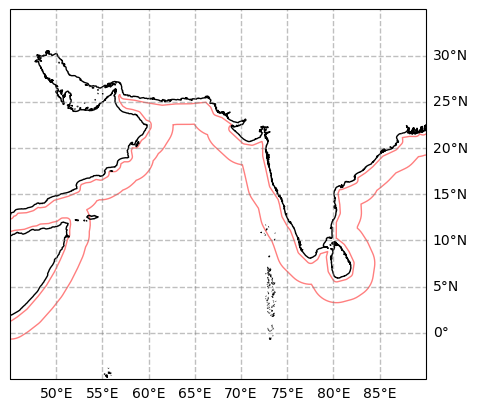

In [3]:
# Define the projection as Plate Carree
crs = ccrs.PlateCarree()

# Define the latitude and longitude boundaries
lats = slice(-5, 35)
lons = slice(45, 90)

# Load the natural earth low resolution dataset as a GeoDataFrame
coastline = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Define a bounding box as a Polygon within the given latitude and longitude boundaries
# Convert the bounding box to a GeoDataFrame and set its Coordinate Reference System (CRS)
bbox = Polygon([(lons.start, lats.start), (lons.start, lats.stop), (lons.stop, lats.stop), (lons.stop, lats.start)])
bbox_gdf = gpd.GeoDataFrame(gpd.GeoSeries(bbox), columns=['geometry'])
bbox_gdf.set_crs('EPSG:4326', inplace=True)

# Clip the coastline GeoDataFrame with the bounding box GeoDataFrame
coastline_clipped = gpd.clip(coastline, bbox_gdf)

# Convert the clipped coastline GeoDataFrame to the Universal Transverse Mercator (UTM) coordinate system (zone 43N)
coastline_utm_clipped = coastline_clipped.to_crs('EPSG:32643')

# Define distances for buffering
distances = [50000, 300000]

# Create buffered geometries based on the defined distances
buffered = []
for distance in distances:
    buffer = coastline_utm_clipped.buffer(distance)
    buffered.append(buffer)

# Convert buffered geometries to GeoDataFrames, unify them, set their CRS to UTM zone 43N, and convert them to WGS84 CRS
buffered_gdfs = []
for b in buffered:
    unified = shapely.ops.unary_union(b)
    gdf = gpd.GeoDataFrame(gpd.GeoSeries(unified), columns=['geometry'])
    gdf.set_crs('EPSG:32643', inplace=True)
    buffered_gdfs.append(gdf)

buffered_wgs84 = [gdf.to_crs('EPSG:4326') for gdf in buffered_gdfs]

# Unify all buffered geometries
union_buffered = unary_union(buffered)

# Begin plotting
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the extent of the axes to the latitude and longitude boundaries
ax.set_extent([lons.start, lons.stop, lats.start, lats.stop], crs=ccrs.PlateCarree())

# Add coastline to the plot
ax.coastlines(resolution='10m', color='black', linewidth=1)

# Add gridlines to the plot
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(range(int(lons.start), int(lons.stop)+1, 5))   # Set longitude markers every 5 degrees
gl.ylocator = mticker.FixedLocator(range(int(lats.start), int(lats.stop)+1, 5))   # Set latitude markers every 5 degrees

# Plot buffers on the map, skipping any empty geometries and handling both Polygon and MultiPolygon types
for buf in buffered_wgs84:
    for geom in buf.geometry:
        if geom.is_empty:
            continue
        if geom.geom_type == 'Polygon':
            geom = MultiPolygon([geom])
        for polygon in geom.geoms:
            x, y = polygon.exterior.coords.xy
            coords = np.column_stack((x, y))
            mpl_poly = mplPolygon(coords, edgecolor='red', facecolor='none', alpha=0.5)
            ax.add_patch(mpl_poly)

# Set the axes limits to your bounding box
ax.set_xlim([lons.start, lons.stop])
ax.set_ylim([lats.start, lats.stop])

# Show the plot
plt.show()

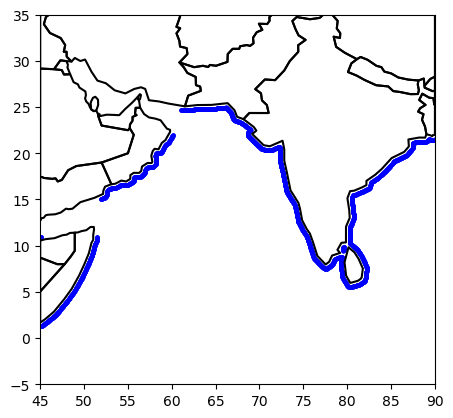

In [15]:
# Define a function to generate a set of sample points within a specified buffer GeoDataFrame
def sample_points(buffer_gdf, dist):
    # Initialize an empty GeoDataFrame to store the sampled points
    sampled_points = gpd.GeoDataFrame(columns=['geometry'])

    # Loop through the geometries in the buffer GeoDataFrame
    for geom in buffer_gdf.geometry:
        # Get the boundary of the current geometry and calculate its length
        boundary = geom.boundary
        length = boundary.length

        # Calculate the number of points to sample based on the specified distance between points
        num_points = int(length / dist)

        # Loop through the number of points and interpolate a point at each fraction along the boundary
        for i in range(num_points):
            fraction = i / num_points
            point = boundary.interpolate(fraction, normalized=True)

            # Append the interpolated point to the GeoDataFrame
            sampled_points.loc[len(sampled_points)] = Point(point)

    return sampled_points

# Set the distance between sample points and generate the sampled points
temp = 0.05
sampled_points_50km = sample_points(buffered_wgs84[0], temp)

# Define latitude and longitude boundaries for noise removal
lats_bounds = [-5, 35]
lons_bounds = [45, 90]

# Remove noise from the sampled points by filtering out points that lie outside the defined boundaries
sampled_points_50km = sampled_points_50km[
    (sampled_points_50km.geometry.y >= lats_bounds[0]) &
    (sampled_points_50km.geometry.y <= lats_bounds[1]) &
    (sampled_points_50km.geometry.x >= lons_bounds[0]) &
    (sampled_points_50km.geometry.x <= lons_bounds[1])
]

# Additional noise removal with custom geographic filters
sampled_points_50km = sampled_points_50km[~((sampled_points_50km.geometry.y >= 24) &
                                              (sampled_points_50km.geometry.y < 30) &
                                              (sampled_points_50km.geometry.x > 45) &
                                              (sampled_points_50km.geometry.x <= 57))]

sampled_points_50km = sampled_points_50km[~((sampled_points_50km.geometry.y >= 11) &
                                              (sampled_points_50km.geometry.y < 15) &
                                              (sampled_points_50km.geometry.x > 45) &
                                              (sampled_points_50km.geometry.x <= 52))]

sampled_points_50km = sampled_points_50km[~((sampled_points_50km.geometry.y >= 22) &
                                              (sampled_points_50km.geometry.y < 27) &
                                              (sampled_points_50km.geometry.x > 55) &
                                              (sampled_points_50km.geometry.x <= 61))]

# Reindex the GeoDataFrame
sampled_points_50km = sampled_points_50km.reset_index(drop=True)

# Plot the sampled points and the clipped coastline
fig, ax = plt.subplots()
sampled_points_50km.plot(ax=ax, color='blue', markersize=5)
coastline_clipped.boundary.plot(ax=ax, color='black')

# Set the limits of the plot to the specified latitude and longitude boundaries
plt.xlim([45, 90])
plt.ylim([-5, 35])

# Show the plot
plt.show()

/tmp/ipykernel_2047/1415093652.py:12: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


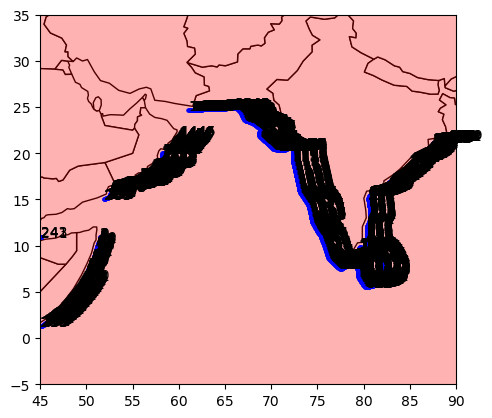

In [16]:
# Convert the sampled points to a pandas DataFrame
df = pd.DataFrame({
    'Longitude': [point.x for point in sampled_points_50km.geometry],  # Extract x coordinate of each point
    'Latitude': [point.y for point in sampled_points_50km.geometry],  # Extract y coordinate of each point
    'index': sampled_points_50km.index  # Preserve the original indices of the points
})

# Convert the pandas DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

# Load a world map GeoDataFrame
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Define a bounding box
box = gpd.GeoSeries([Polygon([(45, -5), (45, 35), (90, 35), (90, -5)])], crs='EPSG:4326')

# Plot the world map with black edgecolor
base = world.plot(color='white', edgecolor='black')

# Plot the bounding box on the world map
box.plot(ax=base, color='red', alpha=0.3)

# Plot the sampled points on the map
gdf.plot(ax=base, marker='o', color='blue', markersize=5)

# Label the sampled points with their indices
for x, y, label in zip(df.Longitude, df.Latitude, df.index):
    plt.text(x, y, label)

# Set the limits of the plot to the specified latitude and longitude boundaries
plt.xlim([45, 90])
plt.ylim([-5, 35])

# Show the plot
plt.show()

In [17]:
def get_nearest_points(source_points, candidate_points, lons_bounds, lats_bounds):
    # Initialize a GeoDataFrame to store the nearest points
    nearest_points = gpd.GeoDataFrame(columns=['geometry'])

    # Filter the candidate points to only those within the specified longitude and latitude bounds
    candidate_points = candidate_points[
        (candidate_points.geometry.y >= lats_bounds[0]) &
        (candidate_points.geometry.y <= lats_bounds[1]) &
        (candidate_points.geometry.x >= lons_bounds[0]) &
        (candidate_points.geometry.x <= lons_bounds[1])
    ]

    # Iterate over each source point
    for i, source_point in enumerate(source_points.geometry):
        # Compute the distances from the current source point to all candidate points
        distances = candidate_points.distance(source_point)

        # Find the index of the nearest candidate point
        nearest_point_index = distances.idxmin()

        # Retrieve the nearest candidate point
        nearest_point = candidate_points.loc[nearest_point_index]

        # Append the nearest point to the GeoDataFrame
        nearest_points.loc[i] = nearest_point

    # Return the GeoDataFrame of nearest points
    return nearest_points

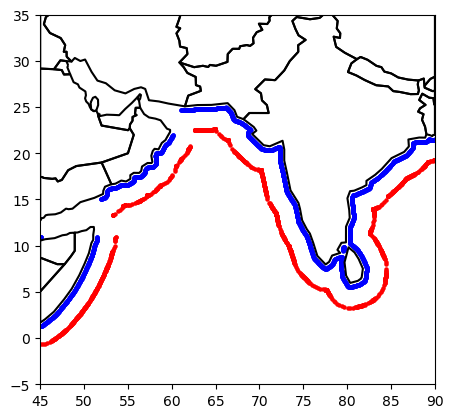

In [18]:
def generate_points(line, distance):
    # Calculate the total length of the line
    total_length = line.length
    # Generate an array of distances from 0 to total_length with a step of `distance`
    distances = np.arange(0, total_length, distance)
    # Generate points along the line at these distances
    points = [line.interpolate(d) for d in distances]
    return points

# Initialize an empty list to store all points
all_points_300km = []
# Iterate over each boundary in the buffered GeoDataFrame
for boundary in buffered_wgs84[1].boundary:
    # Handle LineString and MultiLineString differently
    if boundary.geom_type == 'LineString':
        lines = [boundary]
    elif boundary.geom_type == 'MultiLineString':
        lines = boundary
    # Generate points along each line
    for line in lines:
        points = generate_points(line, 0.01) # Adjust the distance here
        # Extend the list of all points with these new points
        all_points_300km.extend(points)
# Convert the list of points to a GeoDataFrame
all_points_300km_gdf = gpd.GeoDataFrame(gpd.GeoSeries(all_points_300km), columns=['geometry'])

# Find the nearest points on the 300km buffer for each point on the 100km buffer
nearest_points = get_nearest_points(sampled_points_50km, all_points_300km_gdf,
                                    lons_bounds, lats_bounds)

# Create a new plot
fig, ax = plt.subplots()
# Plot the nearest points in red
nearest_points.plot(ax=ax, color='red', markersize=5)
# Plot the sampled points in blue
sampled_points_50km.plot(ax=ax, color='blue', markersize=5)
# Plot the coastline
coastline_clipped.boundary.plot(ax=ax, color='black')
# Set the longitude and latitude limits of the plot
plt.xlim([45, 90])
plt.ylim([-5, 35])

# Display the plot
plt.show()

In [19]:
# Save the 'sampled_points_50km' GeoDataFrame as a pickle file
with open('sampled_points_50km.pickle', 'wb') as handle:
    # Use the highest protocol available for efficient serialization
    pickle.dump(sampled_points_50km, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
with open('nearest_points_300km.pickle', 'wb') as handle:
    pickle.dump(nearest_points, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
from pathlib import Path
import xarray as xr
import numpy as np
import calendar
import os.path
zarr_ds = xr.open_zarr(store='/home/jovyan/shared/data/INDIAN_OCEAN_025GRID_DAILY.zarr', consolidated=True)
zarr_ds

<xarray.Dataset>
Dimensions:          (time: 16071, lat: 177, lon: 241)
Coordinates:
  * lat              (lat) float32 32.0 31.75 31.5 31.25 ... -11.5 -11.75 -12.0
  * lon              (lon) float32 42.0 42.25 42.5 42.75 ... 101.5 101.8 102.0
  * time             (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2022-12-31
Data variables: (12/19)
    CHL              (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_uncertainty  (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    adt              (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    air_temp         (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    curr_dir         (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    curr_speed       (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    ...               ...
    ug_curr          (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    v_curr           (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    v_wind           (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    vg_curr          (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    wind_dir         (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    wind_speed       (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
Attributes: (12/17)
    creator_email:              minhphan@uw.edu
    creator_name:               Minh Phan
    creator_type:               person
    date_created:               2023-07-19
    geospatial_lat_max:         32.0
    geospatial_lat_min:         -12.0
    ...                         ...
    geospatial_lon_units:       degrees_east
    source:                     Earth & Space Research (ESR), Copernicus Clim...
    summary:                    Daily mean of 0.25 x 0.25 degrees gridded dat...
    time_coverage_end:          2022-12-31T23:59:59
    time_coverage_start:        1979-01-01T00:00:00
    title:                      Climate Data for Coastal Upwelling Machine Le...

In [23]:
# Define latitude and longitude range as slices
lats = slice(35, -5)
lons = slice(45, 90)

# This function finds the nearest sea surface temperature (SST) for a given point using a spatial tree.
def find_nearest_sst(point, tree, ds):
    # Get coordinates from the point
    lon, lat = point.x, point.y
    # Query the tree to find the nearest point and get its index
    _, idx = tree.query(np.array([lon, lat]), k=1)
    # Use the index to get the corresponding SST from the data
    nearest_sst = ds['sst'].values.ravel()[idx]
    # Return the SST
    return nearest_sst

# This function calculates the difference in SST between two sets of points
def get_sst_difference(ds, points1, points2, tree):
    # Initialize an empty list to hold the SST differences
    sst_diff = []
    # Iterate over pairs of points
    for point1, point2 in zip(points1, points2):
        # Find the SST for each point
        sst1 = find_nearest_sst(point1, tree, ds)
        sst2 = find_nearest_sst(point2, tree, ds)
        # Calculate the difference and append it to the list
        sst_diff.append(sst1 - sst2)
    return sst_diff

In [24]:
zarr_new = zarr_ds.sel(lat=slice(35, -5), lon=slice(45,90))

all_nan_dates = np.isnan(zarr_new["sst"]).all(dim=["lon", "lat"]).compute()

zarr_ds = zarr_new.sel(time=all_nan_dates == False)

zarr_ds

<xarray.Dataset>
Dimensions:          (time: 15058, lat: 149, lon: 181)
Coordinates:
  * lat              (lat) float32 32.0 31.75 31.5 31.25 ... -4.5 -4.75 -5.0
  * lon              (lon) float32 45.0 45.25 45.5 45.75 ... 89.5 89.75 90.0
  * time             (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2022-12-31
Data variables: (12/19)
    CHL              (time, lat, lon) float32 dask.array<chunksize=(100, 149, 181), meta=np.ndarray>
    CHL_uncertainty  (time, lat, lon) float32 dask.array<chunksize=(100, 149, 181), meta=np.ndarray>
    adt              (time, lat, lon) float32 dask.array<chunksize=(100, 149, 181), meta=np.ndarray>
    air_temp         (time, lat, lon) float32 dask.array<chunksize=(100, 149, 181), meta=np.ndarray>
    curr_dir         (time, lat, lon) float32 dask.array<chunksize=(100, 149, 181), meta=np.ndarray>
    curr_speed       (time, lat, lon) float32 dask.array<chunksize=(100, 149, 181), meta=np.ndarray>
    ...               ...
    ug_curr          (time, lat, lon) float32 dask.array<chunksize=(100, 149, 181), meta=np.ndarray>
    v_curr           (time, lat, lon) float32 dask.array<chunksize=(100, 149, 181), meta=np.ndarray>
    v_wind           (time, lat, lon) float32 dask.array<chunksize=(100, 149, 181), meta=np.ndarray>
    vg_curr          (time, lat, lon) float32 dask.array<chunksize=(100, 149, 181), meta=np.ndarray>
    wind_dir         (time, lat, lon) float32 dask.array<chunksize=(100, 149, 181), meta=np.ndarray>
    wind_speed       (time, lat, lon) float32 dask.array<chunksize=(100, 149, 181), meta=np.ndarray>
Attributes: (12/17)
    creator_email:              minhphan@uw.edu
    creator_name:               Minh Phan
    creator_type:               person
    date_created:               2023-07-19
    geospatial_lat_max:         32.0
    geospatial_lat_min:         -12.0
    ...                         ...
    geospatial_lon_units:       degrees_east
    source:                     Earth & Space Research (ESR), Copernicus Clim...
    summary:                    Daily mean of 0.25 x 0.25 degrees gridded dat...
    time_coverage_end:          2022-12-31T23:59:59
    time_coverage_start:        1979-01-01T00:00:00
    title:                      Climate Data for Coastal Upwelling Machine Le...

In [ ]:
import dask.array as da

def get_nearest_idx(dataset, lat, lon):
    lat_idx = abs(dataset.lat - lat).argmin().item()
    lon_idx = abs(dataset.lon - lon).argmin().item()
    return (lat_idx, lon_idx)

# Precompute indices for all pairs of points
near_indices = [get_nearest_idx(zarr_ds["sst"], pt.y, pt.x) for pt in sampled_points_50km.geometry]
off_indices = [get_nearest_idx(zarr_ds["sst"], pt.y, pt.x) for pt in nearest_points.geometry]

# Convert indices to dask arrays for vectorized operations
near_lat_indices, near_lon_indices = zip(*near_indices)
near_lat_indices = da.from_array(near_lat_indices)
near_lon_indices = da.from_array(near_lon_indices)

off_lat_indices, off_lon_indices = zip(*off_indices)
off_lat_indices = da.from_array(off_lat_indices)
off_lon_indices = da.from_array(off_lon_indices)

data_list = []

# Iterate over times in the dataset
for time in zarr_ds["time"].values:
    print(f"Processing for time: {time}")
    subset = zarr_ds.sel(time=time)
    
    # Vectorized SST extraction
    sst_near_values = subset["sst"].isel(lat=near_lat_indices, lon=near_lon_indices).values
    sst_off_values = subset["sst"].isel(lat=off_lat_indices, lon=off_lon_indices).values

    # Filter out nan values using dask
    valid_mask = ~da.logical_or(da.isnan(sst_near_values), da.isnan(sst_off_values))
    sst_near_values, sst_off_values = da.compute(sst_near_values[valid_mask], sst_off_values[valid_mask])
    
    # Calculate differences and store results
    sst_diff_vals = sst_near_values - sst_off_values
    for near_val, off_val, diff_val, near_point, off_point in zip(sst_near_values, sst_off_values, sst_diff_vals, sampled_points_50km.geometry, nearest_points.geometry):
        data_list.append([time, near_point, off_point, near_val, off_val, diff_val])

# Convert data list to DataFrame and save to CSV
df = pd.DataFrame(data_list, columns=["time", "near_shore_point", "off_shore_point", "sst_near_shore", "sst_off_shore", "sst_diff"])
df.to_csv('/home/jovyan/shared/jiarui-notebooks/sst_difference.csv', index=False)

Processing for time: 1979-01-01T00:00:00.000000000
Processing for time: 1979-01-02T00:00:00.000000000
Processing for time: 1979-01-03T00:00:00.000000000
Processing for time: 1979-01-04T00:00:00.000000000
Processing for time: 1979-01-05T00:00:00.000000000
Processing for time: 1979-01-06T00:00:00.000000000
Processing for time: 1979-01-07T00:00:00.000000000
Processing for time: 1979-01-08T00:00:00.000000000
Processing for time: 1979-01-09T00:00:00.000000000
Processing for time: 1979-01-10T00:00:00.000000000
Processing for time: 1979-01-11T00:00:00.000000000
Processing for time: 1979-01-12T00:00:00.000000000
Processing for time: 1979-01-13T00:00:00.000000000
Processing for time: 1979-01-14T00:00:00.000000000
Processing for time: 1979-01-15T00:00:00.000000000
Processing for time: 1979-01-16T00:00:00.000000000
Processing for time: 1979-01-17T00:00:00.000000000
Processing for time: 1979-01-18T00:00:00.000000000
Processing for time: 1979-01-19T00:00:00.000000000
Processing for time: 1979-01-20